In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as DataLoader
import torchvision.datasets as datasets
import torch.utils.tensorboard as SummaryWriter

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, )
from tensorflow.keras.optimizers import Adam

**Dataset Preparation**

In [ ]:
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([X_train, X_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
print(type(mnist_digits))


11490434/11490434 [==============================] - 1s 0us/step
<class 'numpy.ndarray'>


In [ ]:
dataset=tf.data.Dataset.from_tensor_slices(mnist_digits)
BATCH_SIZE=128
LATENT_DIM=2

In [ ]:
train_dataset=(
    dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
)

In [ ]:
train_dataset


<_PrefetchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

**Modelling**

**Sampling**

In [ ]:
class Sampling(Layer):
  def call(self, inputs):
    mean, log_var = inputs
    return mean + tf.math.exp(0.5*log_var)*tf.random.normal(shape = (tf.shape(mean)[0], tf.shape(mean)[1]))

**Encoder**

In [ ]:
encoder_inputs = Input(shape=(28,28,1))

x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)

x = Flatten()(x)
x = Dense(16, activation='relu')(x)

mean = Dense(LATENT_DIM,)(x)
log_var = Dense(LATENT_DIM,)(x)

z = Sampling()([mean,log_var])

encoder_model = Model(encoder_inputs,[z,mean,log_var], name='encoder')
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

**Decoder**

In [ ]:
latent_inputs=Input(shape=(LATENT_DIM,))
x=Dense(7*7*64,activation='relu')(latent_inputs)
x=Reshape((7,7,64))(x)
x=Conv2DTranspose(64,3,activation='relu',strides=2,padding='same')(x)
x=Conv2DTranspose(32,3,activation='relu',strides=2,padding='same')(x)
decoder_output=Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)
decoder_model=Model(latent_inputs,decoder_output,name='decoder')
decoder_model.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

**Overall VAE Model**

In [ ]:
vae_input=Input(shape=(28,28,1)) # Image is of 28x28 dimension
z,_,_=encoder_model(vae_input)
output=decoder_model(z) # Just need the Z as the output
vae=Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         65089     
                                                                 
Total params: 134165 (524.08 KB)
Trainable params: 134165 (524.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
for i in range(3):
  print(vae.layers[i])

**Training**

In [ ]:
Optimizer=Adam(learning_rate=1e-3)
Epochs=30

In [ ]:
def custom_loss(y_true,y_pred,mean,log_var):

  loss_rec = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred), axis = (1,2)))

  loss_reg = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))

  return loss_rec+tf.reduce_mean(tf.reduce_sum(loss_reg, axis=1))   #

In [ ]:
@tf.function
def training_block(x_batch):
  with tf.GradientTape() as recorder:
    z,mean,log_var = encoder_model(x_batch)
    y_pred = decoder_model(z)
    y_true = x_batch
    loss = custom_loss(y_true,y_pred, mean, log_var)

  partial_derivatives = recorder.gradient(loss,vae.trainable_weights)
  Optimizer.apply_gradients(zip(partial_derivatives, vae.trainable_weights))
  return loss

In [ ]:
def DAN(epochs):
  for epoch in range(1,epochs+1):
    print('Training starts for epoch number {}'.format(epoch))

    for step, X_batch in enumerate(train_dataset):
      loss = training_block(X_batch)
    print('Training Loss is: ', loss)
  print('Training Complete!!!')

In [ ]:
DAN(30)

Training starts for epoch number 1
Training Loss is:  tf.Tensor(193.90071, shape=(), dtype=float32)
Training starts for epoch number 2
Training Loss is:  tf.Tensor(175.1516, shape=(), dtype=float32)
Training starts for epoch number 3
Training Loss is:  tf.Tensor(164.56299, shape=(), dtype=float32)
Training starts for epoch number 4
Training Loss is:  tf.Tensor(162.84506, shape=(), dtype=float32)
Training starts for epoch number 5
Training Loss is:  tf.Tensor(158.65123, shape=(), dtype=float32)
Training starts for epoch number 6


KeyboardInterrupt: 

**Overriding Step**

In [18]:
class VAE(tf.keras.Model):
  def __init__(self,encoder_model,decoder_model):
    super(VAE,self).__init__()
    self.encoder=encoder_model
    self.decoder=decoder_model
    self.loss_tracker=tf.keras.metrics.Mean(name='loss')
  @property
  def metrics(self):
    return [self.loss_tracker]
  def train_step(self,X_batch):
    with tf.GradientTape() as recorder:
      z,mean,log_var=self.encoder(X_batch)
      y_pred=self.decoder(z)
      y_true=X_batch
      loss=custom_loss(y_true,y_pred,mean,log_var)

    partial_derivatives=recorder.gradient(loss,self.trainable_weights)
    Optimizer.apply_gradients(zip(partial_derivatives,self.trainable_weights))
    self.loss_tracker.update_state(loss)
    return {'loss':self.loss_tracker.result()}

In [20]:
model=VAE(encoder_model,decoder_model)
model.compile(optimizer=Optimizer)
model.fit(train_dataset,epochs=1)

547/547 [==============================] - 94s 169ms/step - loss: 160.4174


**Testing**

1/1 [==============================] - 0s 35ms/step


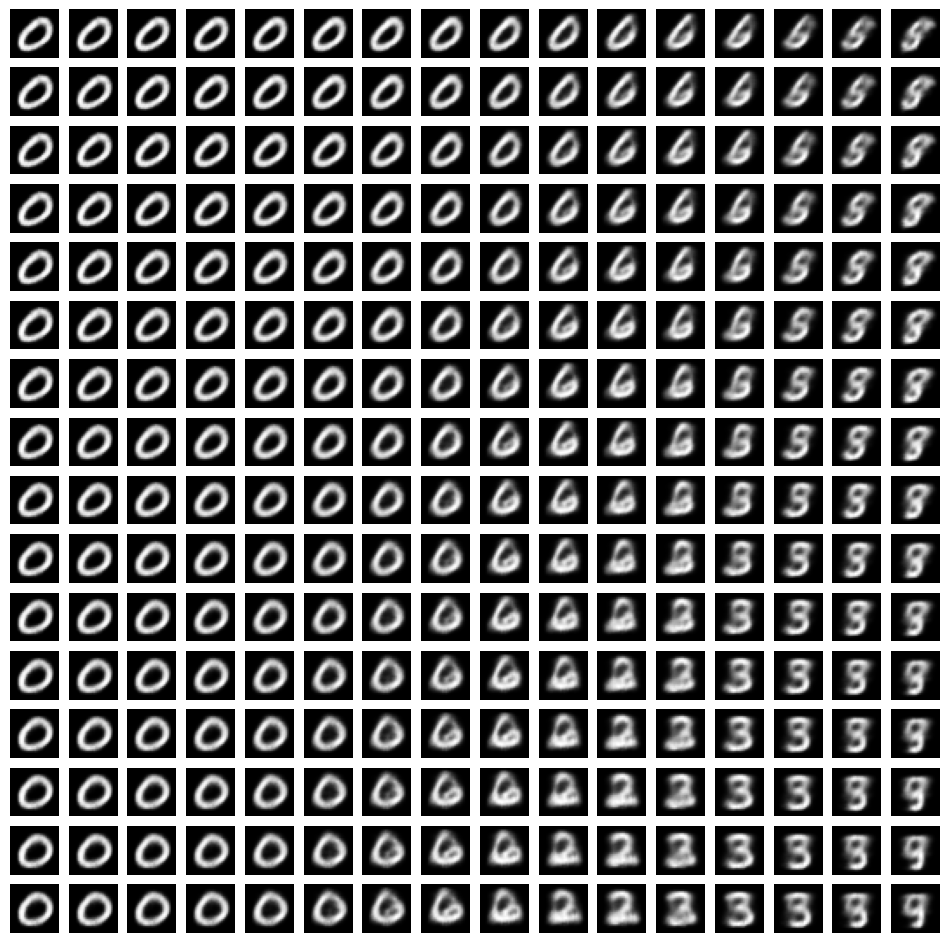

In [22]:
scale=1
n=16
grid_x=np.linspace(-1,1,n)
grid_y=np.linspace(-1,1,n)
plt.figure(figsize=(12,12))
k=0
for i in grid_x:
  for j in grid_y:
    ax=plt.subplot(n,n,k+1)
    input=tf.constant([[i,j]]) # Giving input of different points from the latent space
    out=model.decoder.predict(input)[0][...,0] # Elipsis notation of choosing all the elements along the channel 0..Often used in RGB notation.
    plt.imshow(out,cmap="Greys_r")
    plt.axis('off')
    k+=1
plt.show()
